<a href="https://colab.research.google.com/github/thijssavelberg/Bio-Inspired_Assignment_SNN_N-MNIST_Thijs_Savelberg/blob/main/Assignment_SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment for the course AE4350:Bio-Inspired Intelligence and Learning for Aerospace Applications by Thijs Savelberg.

This code and the mathematics used in this code are inspired by and based on earlier work of the following authors/researchers:

- W. F. Yaoyu Zhu Zhaofei Yu
- D. Goodman
- J. Eshraghian
- Z. M. Yufei Guo Xuhui Huang
- J. C.-R. Kai Malcom
- W. Maas

The N-MNIST dataset used in this assignment was obtained from TONIC.

Installation of Tonic, SnnTorch and reinstallation of Thinc to Slove dependency conflict

In [ ]:
# Install Tonic: library for event-based vision datasets (N-MNIST)
!pip install tonic

# Install snnTorch: simplifies building spiking neural networks in PyTorch
!pip install snntorch

# Force-reinstall thinc and numpy to avoid compatibility issues (especially with snnTorch)
# Note that for some reaon this block should bu run twice to solve the dependency conflict
!pip install --upgrade --force-reinstall thinc numpy


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blis 1.0.2 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
thinc 9.1.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
spacy 3.8.5 requires thinc<8.4.0,>=8.3.4, but you have thinc 9.1.1 which is incompatible.
  Using cached thinc-9.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached blis-1.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
  Using cached murmurhash-1.0.12-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached cymem-2.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata 

Data setup and preprocessing:

In [ ]:
# Import necessary libraries for dataset handling and preprocessing
import tonic
import tonic.transforms as transforms
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset
import torch
import torchvision

# Define parameters for preprocessing
filter_time = 8000        # microseconds — filter out isolated events shorter than 8ms
time_window = 1500        # microseconds — bin events into frames every 1ms

# Load raw N-MNIST dataset (for reference, not used directly here)
dataset = tonic.datasets.NMNIST(save_to='./data', train=True)

# Get the sensor resolution of the DVS used in N-MNIST
sensor_size = tonic.datasets.NMNIST.sensor_size

# Set up event preprocessing:
# - event_filter: removes isolated spikes
# - frame_converter: converts spikes into time-binned frames
event_filter = transforms.Denoise(filter_time=filter_time)
frame_converter = transforms.ToFrame(sensor_size=sensor_size, time_window=time_window)
frame_transform = transforms.Compose([event_filter, frame_converter])

# Apply preprocessing to both training and test sets
trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=False)

# Cache the processed training dataset to avoid repeated transformations
cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')

# Load a single sample without batching — useful for debugging or inspection
cached_dataloader = DataLoader(cached_trainset)

# Set the batch size (128 is most often used for N-MNIST)
batch_size = 128

# Prepare training DataLoader with padded tensors for uniform batch shapes
trainloader = DataLoader(
    cached_trainset,
    batch_size=batch_size,
    collate_fn=tonic.collation.PadTensors()
)

# Convenience function to retrieve one (unbatched) sample
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

# Define augmentation parameters
rotation_range = [-12, 12]  # Rotate frames between -12 and +12 degrees

# Define augmentation process for the training set:
# - Convert numpy arrays to PyTorch tensors
# - Apply random rotation within the defined range
train_augmentations = tonic.transforms.Compose([
    torch.from_numpy,
    torchvision.transforms.RandomRotation(degrees=rotation_range)
])

# Wrap training dataset with on-the-fly augmentations and caching
cached_trainset = DiskCachedDataset(trainset, transform=train_augmentations, cache_path='./cache/nmnist/train')

# No augmentation for test set — just cache it for efficiency
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

# Define collate function to pad sequences in each batch (not enforcing batch_first)
collate_fn = tonic.collation.PadTensors(batch_first=False)

# Set up DataLoaders for training and testing
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=collate_fn)


Definition of the network architecture:



In [ ]:

# Import SNN-related libraries
import snntorch as snn
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import surrogate
from snntorch import utils

# PyTorch components
import torch.nn as nn

# Set device based on availability
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define neuron behavior and simulation parameters
grad_fn = surrogate.atan()   # Surrogate gradient function for backprop
mem_decay = 0.6              # Membrane potential decay rate (increased slightly from typical)


# Build the spiking neural network model
# Define key architecture parameters
input_channels = 2
hidden_channels_1 = 12
hidden_channels_2 = 32
kernel_size = 5
pool_size = 2
linear_input_dim = hidden_channels_2 * 5 * 5  # after conv + pooling
num_classes = 10

# Create the spiking neural network using modular components
conv_block_1 = nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels_1, kernel_size=kernel_size)
snn_block_1 = snn.Leaky(beta=mem_decay, spike_grad=grad_fn, init_hidden=True)

conv_block_2 = nn.Conv2d(in_channels=hidden_channels_1, out_channels=hidden_channels_2, kernel_size=kernel_size)
snn_block_2 = snn.Leaky(beta=mem_decay, spike_grad=grad_fn, init_hidden=True)

snn_output = snn.Leaky(beta=mem_decay, spike_grad=grad_fn, init_hidden=True, output=True)

# Assemble the network
net = nn.Sequential(
    conv_block_1,
    snn_block_1,
    nn.MaxPool2d(kernel_size=pool_size),

    conv_block_2,
    snn_block_2,
    nn.MaxPool2d(kernel_size=pool_size),

    nn.Flatten(),
    nn.Linear(linear_input_dim, num_classes),
    snn_output
).to(device)



Initializing the Forward Pass:

In [ ]:
# Forward pass through the SNN
def run_forward(model, input_sequence):
    # Initialize list to collect spikes over time
    spike_sequence = []

    # Reset all neuron states (required for sequential input)
    utils.reset(model)

    # Simulate each time step in the input sequence
    for t in range(input_sequence.shape[0]):
        spikes, _ = model(input_sequence[t])  # we ignore the membrane output here
        spike_sequence.append(spikes)

    # Stack the spikes across time steps into a single tensor
    return torch.stack(spike_sequence)


Training Through Backpropagation with Surrogate Gradient Descent:

In [ ]:
# Define training hyperparameters
learning_rate = 0.02
betas = (0.9, 0.999)
num_epochs = 1
max_batches_per_epoch = 100  # Early stopping for sensitivity analysis

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=betas)
loss_function = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

# Containers to track loss and accuracy over time
loss_history = []
accuracy_history = []

# Begin training loop
for epoch in range(num_epochs):
    for batch_num, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Set model to training mode and run forward pass
        net.train()
        spike_output = run_forward(net, inputs)
        loss = loss_function(spike_output, labels)

        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record training metrics
        loss_history.append(loss.item())
        accuracy = SF.accuracy_rate(spike_output, labels)
        accuracy_history.append(accuracy)

        # Output training progress
        print(f"[Epoch {epoch} | Batch {batch_num}]  Loss = {loss.item():.4f}   Accuracy = {accuracy * 100:.1f}%")

        # Optionally limit training to a fixed number of batches per epoch
        if batch_num == max_batches_per_epoch:
            break

[Epoch 0 | Batch 0]  Loss = 61.5205   Accuracy = 9.4%
[Epoch 0 | Batch 1]  Loss = 61.5809   Accuracy = 10.2%
[Epoch 0 | Batch 2]  Loss = 60.9626   Accuracy = 12.5%
[Epoch 0 | Batch 3]  Loss = 53.8210   Accuracy = 9.4%
[Epoch 0 | Batch 4]  Loss = 44.1518   Accuracy = 8.6%
[Epoch 0 | Batch 5]  Loss = 24.7442   Accuracy = 11.7%
[Epoch 0 | Batch 6]  Loss = 29.2213   Accuracy = 7.0%
[Epoch 0 | Batch 7]  Loss = 34.2970   Accuracy = 11.7%
[Epoch 0 | Batch 8]  Loss = 33.3995   Accuracy = 16.4%
[Epoch 0 | Batch 9]  Loss = 29.8786   Accuracy = 19.5%
[Epoch 0 | Batch 10]  Loss = 27.0214   Accuracy = 15.6%
[Epoch 0 | Batch 11]  Loss = 24.4859   Accuracy = 14.1%
[Epoch 0 | Batch 12]  Loss = 26.4848   Accuracy = 13.3%
[Epoch 0 | Batch 13]  Loss = 27.2899   Accuracy = 21.1%
[Epoch 0 | Batch 14]  Loss = 24.5817   Accuracy = 28.9%
[Epoch 0 | Batch 15]  Loss = 24.8359   Accuracy = 21.1%
[Epoch 0 | Batch 16]  Loss = 24.4913   Accuracy = 26.6%
[Epoch 0 | Batch 17]  Loss = 27.2691   Accuracy = 28.1%
[Epoch

Visualization of the training process:

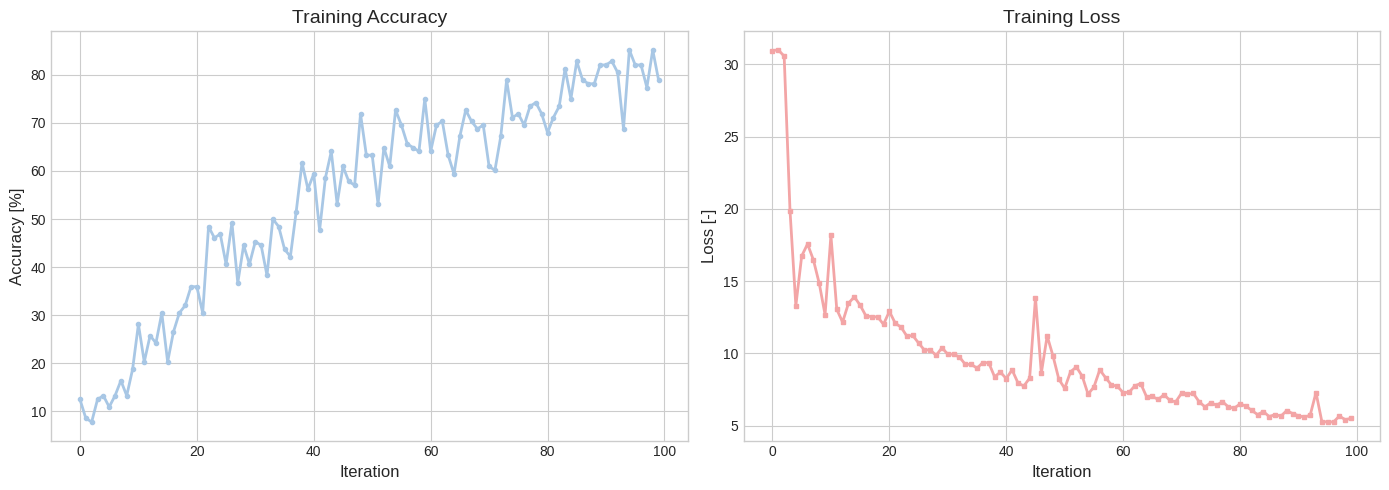

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style
plt.style.use("seaborn-v0_8-whitegrid")

# Convert accuracy to percentage
acc_percent = [a * 100 for a in accuracy_history]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), facecolor="w")

# Accuracy plot (in %)
ax1.plot(acc_percent[1:], marker='o', markersize=3, linewidth=2, color="#a8c7e5")
ax1.set_title("Training Accuracy", fontsize=14)
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("Accuracy [%]", fontsize=12)
ax1.grid(True)

# Loss plot
ax2.plot(loss_history[1:], marker='s', markersize=3, linewidth=2, color="#f3a5a6")
ax2.set_title("Training Loss", fontsize=14)
ax2.set_xlabel("Iteration", fontsize=12)
ax2.set_ylabel("Loss [-]", fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()
#Learning rate colors
#"#1f77b4"
#"#d62728"
#Decay rate colors
##155a8a
##a61b1c
#Time Window Colors


Testing of the Trained Network:

In [1]:
net.eval()
with torch.no_grad():
    test_acc = []
    for data, targets in testloader:
        data = data.to(device)
        targets = targets.to(device)
        spk_rec = run_forward(net, data)
        acc = SF.accuracy_rate(spk_rec, targets)
        test_acc.append(acc)

    avg_test_acc = sum(test_acc) / len(test_acc)
    print(f"Test Accuracy: {avg_test_acc * 100:.2f}%")


NameError: name 'net' is not defined